In [1]:
%matplotlib inline
import cv2
import numpy as np
from skimage import io
from skimage import feature
from skimage import color
from matplotlib import pyplot as plt
import matplotlib.cbook 
import os

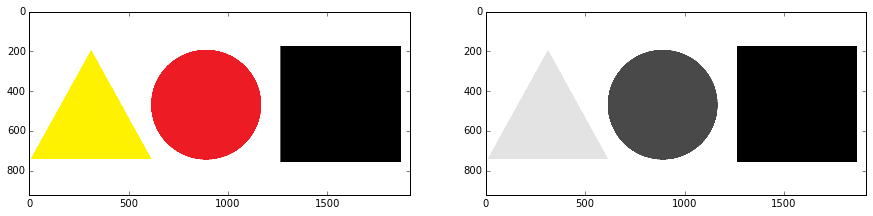

Coordinates: 
[[ 177 1260]
 [ 177 1863]
 [ 755 1260]
 [ 755 1863]]


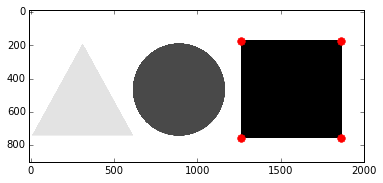

Coordinates: 
[[ 177 1260]
 [ 177 1863]
 [ 197  311]
 [ 589 1136]
 [ 741    9]
 [ 741  612]
 [ 755 1260]
 [ 755 1863]]


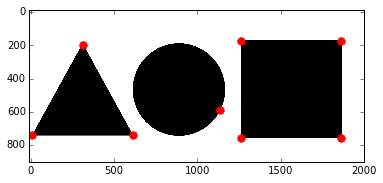

In [2]:
#load and get gray image
shad = io.imread('shad.png')
gray_shad = color.rgb2gray(shad)
plt.figure(figsize=(15, 8)) 
ax1 = plt.subplot2grid((1,2), (0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)
ax1.imshow(shad)
ax2.imshow(gray_shad, 'gray')
plt.show()

#get corners
def draw_corners(img):
    corners = feature.corner_peaks(feature.corner_harris(img), min_distance=5)
    fig, ax = plt.subplots()
    ax.imshow(img, 'gray')
    print 'Coordinates: ' 
    print corners
    ax.plot(corners[:, 1], corners[:, 0], '.r', markersize=15)
    ax.axis((-10, 2000, 900, -10))
    plt.show()
draw_corners(gray_shad)

#binarize and get corners
binary_shad = gray_shad == 1.
draw_corners(binary_shad)

В результате получили, что карта отклика бинаризованного изображения содержит все углы, в отличие от карты отклика исходного изображения.
<ul>
<li><ul>
    <li>Координаты углов треугольника:<br> 
    (9, 741), (612, 741), (311, 197)</li>
    <li>Координаты углов квадрата: <br>
    (1260, 755), (1863, 755), (1863, 177), (1260, 177)</li>
    </ul></li>
<li>Да, можно. Например, для этого предварительно моэно бинаризовать изображение с таким порогом, чтобы на нем остался только квадрат.
</ul>

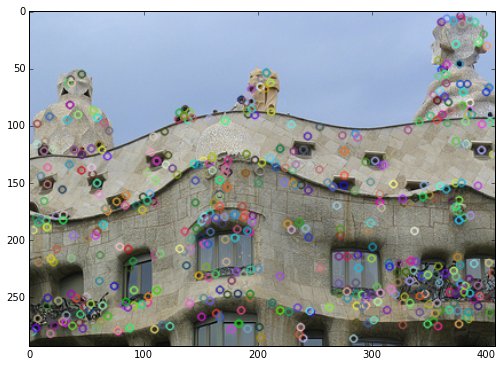

In [29]:
house = cv2.imread('house0.jpg')
house = cv2.cvtColor(house, cv2.COLOR_RGB2BGR)
gray_house = cv2.cvtColor(house, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT()
key_points = sift.detect(house, None)
house_key_points = cv2.drawKeypoints(house, key_points)
plt.figure(figsize=(10, 6)) 
plt.imshow(house_key_points)

Структура KeyPoint определяет особую точку. В ней хранятся следующие поля:<br>
<ul>
<li>pt - координаты особой точки</li>
<li>size - диаметр окрестности особой точки</li>
<li>angle - ориентация особой точки - основное направление градиентов пикселей в окрестности этой точки</li>
<li>response - отклик особой точки, определяет, насколько она важна по сравнению с остальными особыми точками </li>
<li>octave - номер октавы - слоя в прирмиде гауссианов</li>
<li>class_id - идентификатор объекта, который можно использовать для кластеризации особых точек в зависимости от объекта, которому они приндлежат</li>
</ul>

Выбранные точки представляют собой найденные на изображении углы с определенным характеристическим размером. То есть сюда попали основные очертания здания, его крыши и окон, которые в результате изменения масштаба сводятся к углам (которые и были найдены детектором углов Харриса).

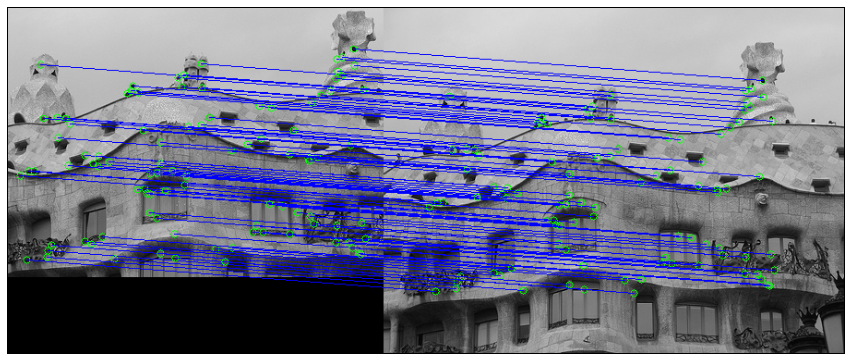

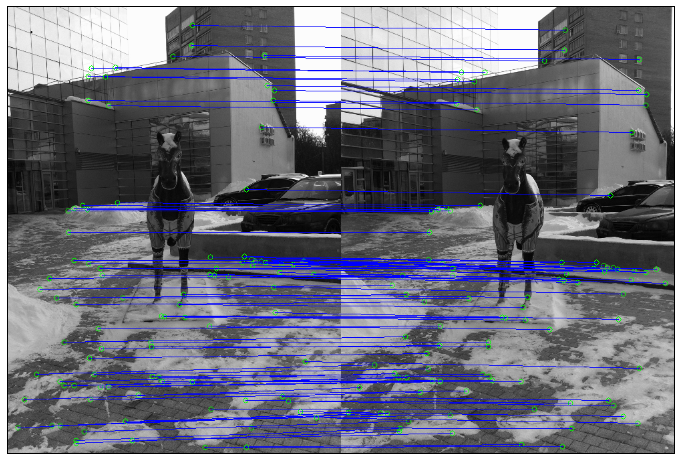

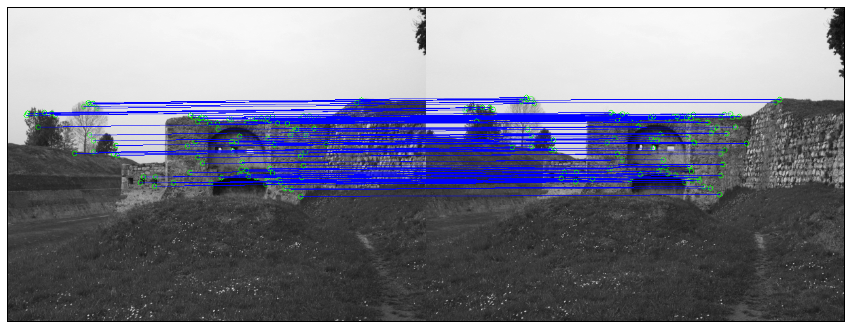

In [35]:
def drawMatches(img1, kp1, img2, kp2, matches):
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])
    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
        cv2.circle(out, (int(x1),int(y1)), 4, (0, 255, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (0, 255, 0), 1)
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)
    plt.figure(figsize=(15, 8)) 
    plt.xticks([]), plt.yticks([])
    plt.imshow(out)
    plt.show()
    return

def matchKeypoints(image_1, image_2):
    img1 = cv2.imread(image_1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.imread(image_2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT()
    k1, descriptors_1 = sift.detectAndCompute(img1, None)
    k2, descriptors_2 = sift.detectAndCompute(img2, None)
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches = matcher.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)[:100]
    drawMatches(img1, k1, img2, k2, matches)
matchKeypoints('house0.jpg', 'house1.jpg')
matchKeypoints('horse0.png', 'horse1.png')
matchKeypoints('fort0.png', 'fort1.png')

На всех изображениях видно, что соответствия были получены достаточно точно. Для  изображений здания соотвествия были найдены точнее всего, потому что они получено в результате масштабирования одного и того же изображения, здесь нет сдвигов и сильных изменений освещения в отличие от других изображений. Поэтому дескрипторы особых точек оказались почти одинаковыми для обоих изображений. 
На втором изображении совем не удолось сопоставить очертания лошади, потому что ее очертания сильно изменились при смещении камеры. 